<a href="https://colab.research.google.com/github/the-SQuAD-squad/IR/blob/tfidf/IR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Init { form-width: "25%" }

import os
import random
import math
import numpy as np
import tensorflow as tf
import json
import pandas as pd
import re
import string
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm

!pip3 install wikipedia-api > null
import wikipediaapi
!pip install tokenizers > null
from tokenizers import BertWordPieceTokenizer

from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_colwidth', -1)

# fix random seeds
seed_value = 42 #@param {type:"integer"}

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

tf.compat.v1.set_random_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# BERT params
max_seq_length = 512
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
#@title df creation { form-width: "25%" }

# the official dataset is identical to the provided one
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json -O training_set.json

with open("training_set.json", "r") as f:
    json_file = json.load(f)
data = json_file["data"]

rows = []
for document in data:
  for par in document['paragraphs']:
    for qas in par['qas']:
      rows.append({
        'id' : qas['id'],
        'title': document["title"],
        'passage': par['context'],
        'question' : qas['question'],
        'answer_idx' : (qas['answers'][0]['answer_start'], 
                    qas['answers'][0]['answer_start'] + len(qas['answers'][0]['text'])),
        'answer_text' : qas['answers'][0]['text']
      })

df_original = pd.DataFrame(rows)

--2021-03-12 18:42:03--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30288272 (29M) [application/json]
Saving to: ‘training_set.json’

training_set.json   100%[===================>]  28.88M  74.7MB/s    in 0.4s    

2021-03-12 18:42:03 (74.7 MB/s) - ‘training_set.json’ saved [30288272/30288272]



In [3]:
#@title preprocessing { form-width: "25%" }

import nltk
import re 
import math
import random as rand

nltk.download('punkt')
from nltk.stem.porter import PorterStemmer # for stemming

from tqdm.notebook import tqdm


def preprocess_text(text):
    """
    Given an iterable containing sentences, pre-process each sentence.

    :param: 
        - text: list of text to be pre-processed (Iterable)
    :return:
        - text: pre-processed text (List)
    """

    REPLACE_WITH_SPACE = re.compile(r"\n") 
    text = [REPLACE_WITH_SPACE.sub(" ", line) for line in text]

    text = [re.sub(r"([(.;:!\'ˈ~?,\"(\[\])\\\/\-–\t```<>_#$€@%*+—°′″“”×’^₤₹‘])", r'', line) for line in text]

    # we noticed that in the text sometimes we find numbers and the following word merged together (ex: 1980february),
    # so we put a space between the number and the word
    text = [re.sub(r"(\d+)([a-z]+)", r'\1 \2', line) for line in text] 
    text = [re.sub('\s{2,}', ' ', line.strip()) for line in text]   # replacing more than one consecutive blank spaces with only one of them

    return text

    """
    stemmed_lines = []
    for line in tqdm(text):
        tokens = nltk.word_tokenize(line)
        stems = []
        for item in tokens:
            stems.append(PorterStemmer().stem(item))
        stemmed_lines.append(' '.join(stems))

    return stemmed_lines
    """

# Creating a copy of the original dataframe (we do this because we want to be able to compare the results of our processing with the original data)
df = df_original.copy()

# pre-process passage and question text
df['passage'] = preprocess_text(df_original['passage'])
df['question'] = preprocess_text(df_original['question'])
df['answer_text'] = preprocess_text(df_original['answer_text'])


# Comparing Original and Pre-Processed
for i in range(3):
    a = rand.randint(0,1000)
    print('ORIGINAL AND PREPROCESSED PASSAGE:')
    print(df_original.iloc[a]['passage'])
    print(df.iloc[a]['passage'])
    
    print()
    print('ORIGINAL AND PREPROCESSED QUESTION:')
    print(df_original.iloc[a]['question'])
    print(df.iloc[a]['question'])
    print()

df["passage"]=df["passage"].str.lower()
df["question"]=df["question"].str.lower()
df["answer_text"]=df["answer_text"].str.lower()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
ORIGINAL AND PREPROCESSED PASSAGE:
In 2015 Beyoncé signed an open letter which the ONE Campaign had been collecting signatures for; the letter was addressed to Angela Merkel and Nkosazana Dlamini-Zuma, urging them to focus on women as they serve as the head of the G7 in Germany and the AU in South Africa respectively, which will start to set the priorities in development funding before a main UN summit in September 2015 that will establish new development goals for the generation.
In 2015 Beyoncé signed an open letter which the ONE Campaign had been collecting signatures for the letter was addressed to Angela Merkel and Nkosazana DlaminiZuma urging them to focus on women as they serve as the head of the G7 in Germany and the AU in South Africa respectively which will start to set the priorities in development funding before a main UN summit in September 2015 that will establis

In [4]:
#@title clean dataset { form-width: "25%" }

!gcloud config set project feisty-mechanic-221914
!gsutil cp gs://squad_squad/error_IDs.txt ./error_IDs.txt

with open("error_IDs.txt", "r") as f:
    unwanted_id = f.read()  # remove samples that contain errors from the dataset

unwanted_id = unwanted_id.split("\n")[:-1]
df_clean = df.set_index('id')
df_clean = df_clean.drop(unwanted_id)

df_original_clean = df_original.set_index('id')
df_original_clean = df_original_clean.drop(unwanted_id)

Updated property [core/project].
Copying gs://squad_squad/error_IDs.txt...
/ [1 files][  5.7 KiB/  5.7 KiB]                                                
Operation completed over 1 objects/5.7 KiB.                                      


In [5]:
#@title train-test split { form-width: "25%" }

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

split_value = 0.1 #@param {type:"number"} 
test_dim = int(len(df_clean['title'].unique()) * split_value)
test_titles = np.random.choice(df_clean['title'].unique(), size=test_dim, replace=False)

# creating train and test sets
df_test = df_clean[df_clean['title'].isin(test_titles)]
df_train = df_clean[~(df_clean['title'].isin(test_titles))]

df_original_test = df_original_clean[df_original_clean['title'].isin(test_titles)]
df_original_train = df_original_clean[~(df_original_clean['title'].isin(test_titles))]

In [6]:
#@title tf-idf { form-width: "25%" }

vectorizer =  TfidfVectorizer()

# get unique preprocessed passages from the training set
passage_prep_train = df_train['passage'].unique().tolist()
# use the tf-idf vectorizer to learn the vocabulary and the inverse document frequency, computing the document-term matrix on the training set
passage_tf_idf = vectorizer.fit_transform(passage_prep_train)

# obtain unique passages from the test set
passage_prep_test = df_test['passage'].unique().tolist() # preprocessed
passage_test = df_original_test['passage'].unique()      # original

# transform test passages and questions
passage_test_tf_idf = vectorizer.transform(passage_prep_test)
question_tf_idf = vectorizer.transform(df_test['question'].tolist())

# compute similarity
results = cosine_similarity(passage_test_tf_idf, question_tf_idf)


[0.5450475657526581, 0.6624230554001119, 0.7250979294907667, 0.7620313374370453, 0.7890318970341355, 0.8115556799104645, 0.8282036933407946, 0.8412143256855065, 0.8538052602126469, 0.8649972020145495]


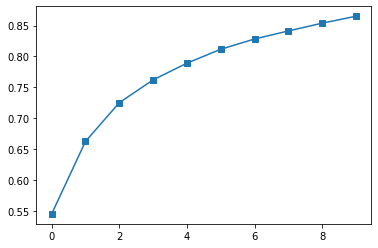

In [7]:
#@title single passage score { form-width: "25%" }

# In this cell we evaluate how effective is tf-idf in finding the right passage for a question

# we compute the result accuracy for each k between 1 and k_results:
# in particular, for each question we take the k most probable passages and check
# if the right passage is among them 
k_results = 10  

tp = 0 #true positives
accuracy = []
for k in tqdm(range(1, k_results+1)):
    for j,result in enumerate(results.T):
        result = np.argsort(result)
        if df_original_test['passage'].tolist()[j] in [text for text in passage_test[result[-k:].tolist()]]:
            tp+=1
    accuracy.append(tp/len(df_original_test))
    tp = 0

print(accuracy,sep='\n')
plt.plot(accuracy,"-s");


[0.8547845551203134, 0.9162003357582541, 0.9360660324566312, 0.9457190822607723, 0.9534135422495803, 0.9597090095131505, 0.9629266927811976, 0.9657246782316732, 0.9682428651371013, 0.9710408505875769]


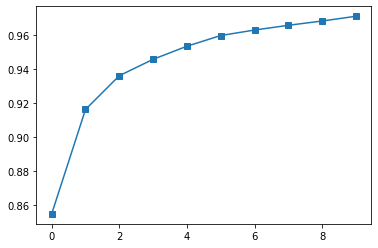

In [8]:
#@title full document score { form-width: "25%" }

# In this cell we evaluate how effective is tf-idf in finding the right document (passage title) for a question

passage_group = df_original_test.groupby('passage').groups

k_results = 10
tp = 0
document_accuracy = []
for k in tqdm(range(1,k_results+1)):
    for j,result in enumerate(results.T):
        result = np.argsort(result)
        for h in range(1,k+1):
            if df_original_test["title"].tolist()[j] == df_original_test.loc[passage_group[passage_test[result[-h]]][0]]['title']:
                tp+=1
                break
    document_accuracy.append(tp/len(df_original_test))
    tp = 0

print(document_accuracy,sep='\n')
plt.plot(document_accuracy,"-s");

# GET READY FOR THE CRUISE NET

In [9]:
#@title Get links from Wiki page { form-width: "25%" }

wiki_wiki = wikipediaapi.Wikipedia('en')
page_py = wiki_wiki.page("Tom Cruise filmography")
def get_links(page):
    links = page.links
    for title in sorted(links.keys()):
        if links[title].ns != 0 or "Unauthorized" in title or "Being Tom Cruise" in title:  # remove some links not strictly related to the tom cruise filmography
            links.pop(title)
    return links

links = get_links(page_py)

In [10]:
#@title Get Wiki pages { form-width: "25%" }

pages_text = {}
for title in tqdm(links):
    page_py = links[title]
    pages_text[title] = page_py.text

# remove the last sections of the wiki page from the text
for title in pages_text:
    stop_index = pages_text[title].rfind("References")
    pages_text[title] = pages_text[title][:stop_index]

In [11]:
#@title preprocess wiki pages { form-width: "25%" }
pages_text_preprocessed = preprocess_text(pages_text.values())
titles = list(pages_text.keys())

In [12]:
#@title tf-idf wiki { form-width: "25%" }
vectorizer =  TfidfVectorizer()

questions = ["When was Tom Cruise born?", "What was the first film Tom Cruise acted in?", "What does Tom Cruise believe in?", "What is Tom Cruise character's name in Mission Impossible?", "What is Vanilla Sky?", "Who directed Mission Impossible?"]

# fit the vectorizer on the preprocessed wikipedia text
passages_vectorized = vectorizer.fit_transform(pages_text_preprocessed)
questions_vectorized = vectorizer.transform(questions)

results = cosine_similarity(questions_vectorized,passages_vectorized)

for i,row in enumerate(results):
    index = np.argmax(row)
    print(questions[i], end = " ---> ")
    print(titles[index])

When was Tom Cruise born? ---> Tom Cruise
What was the first film Tom Cruise acted in? ---> Tom Cruise
What does Tom Cruise believe in? ---> Tom Cruise
What is Tom Cruise character's name in Mission Impossible? ---> Mission: Impossible (film series)
What is Vanilla Sky? ---> Vanilla Sky
Who directed Mission Impossible? ---> Mission: Impossible (film series)


In [13]:
#@title model definition { form-width: "25%" }

!pip install transformers > /dev/null
import transformers

pretrained_model_str = "roberta-base"
bert_hf_layer = transformers.TFRobertaModel.from_pretrained(
    pretrained_model_str, output_attentions=True)

#@title model definition { form-width: "25%" }

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_word_ids')
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_mask')
input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name='input_type_ids')

#pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

#HUGGINGFACE 🤗🤗🤗🤗🤗🤗🤗🤗🤗🤗🤗🤗🤗
sequence_output = bert_hf_layer(input_ids=input_word_ids, attention_mask=input_mask, 
                                token_type_ids=input_type_ids).last_hidden_state

#do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

start_logits = layers.Dense(1, name="start_logit", use_bias=False)(sequence_output)
start_logits = layers.Flatten(name="flatten_start")(start_logits)

end_logits = layers.Dense(1, name="end_logit", use_bias=False)(sequence_output)
end_logits = layers.Flatten(name="flatten_end")(end_logits)

start_probs = layers.Activation(keras.activations.softmax, name="softmax_start")(start_logits)
end_probs = layers.Activation(keras.activations.softmax, name="softmax_end")(end_logits)

model = keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], 
                    outputs=[start_probs, end_probs],
                    name="BERT_QA")

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)

optimizer = keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.summary(line_length=150)

# load weights from the SQuAD v2 training
!wget https://api.wandb.ai/files/buio/SQUAD/jkgwaatn/model-best.h5
model.load_weights("model-best.h5")

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Model: "BERT_QA"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_word_ids (InputLayer)                      [(None, 512)]                    0                                                                   
______________________________________________________________________________________________________________________________________________________
input_mask (InputLayer)                          [(None, 512)]                    0                                                                   
______________________________________________________________________________________________________________________________________________________
input_type_ids (InputLayer)                      [(None, 512)]               

In [14]:
#@title transformer input preparation { form-width: "25%" }

import nltk.data

from  transformers import AutoTokenizer

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy().decode("utf-8")

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_str)
max_seq_length = 512

def preprocess_bert(text):
    tokenized_text = tokenizer(text, return_offsets_mapping=True)

    rows_out = tokenized_text.input_ids

    return rows_out

def custom_inference(context, question):
    tokenizer_nltk = nltk.data.load('tokenizers/punkt/english.pickle')  # sentence tokenizer
    context_sentences = tokenizer_nltk.tokenize(context)
    preprocessed_context = [" ".join(str(line).split()) for line in context_sentences]
    preprocessed_question = " ".join(str(question).split())
    tokenized_question = preprocess_bert(preprocessed_question)
    tokenized_sentences = [preprocess_bert(preprocessed_line) for preprocessed_line in preprocessed_context]
    sentence_index = 0
    tokenized_passages = []

    while sentence_index < len(tokenized_sentences):
        start = sentence_index
        len_count = len(tokenized_question)
        while len_count <= 512 and sentence_index < len(tokenized_sentences):
            len_count += len(tokenized_sentences[sentence_index])
            sentence_index += 1
        end = sentence_index -1
        tokenized_passages.append(preprocess_bert(" ".join(preprocessed_context[start:end])))

    prob = []
    candidate_ans = []
    for tokenized_passage in tokenized_passages:
        input_ids = tokenized_passage + tokenized_question[1:]
        token_type_ids = [0] * len(tokenized_passage) + [1] * len(tokenized_question[1:])
        attention_mask = [1] * len(input_ids)
        padding_length = max_seq_length - len(input_ids)
        if padding_length > 0:
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        input_word_ids = np.array(input_ids)
        input_mask = np.array(attention_mask)
        input_type_ids = np.array(token_type_ids)
        predictions = model.predict([np.expand_dims(input_word_ids, axis =0), 
                                    np.expand_dims(input_mask, axis = 0), 
                                    np.expand_dims(input_type_ids,axis=0)])
        start, end = list(np.argmax(predictions, axis=-1).squeeze())
        if start > end:
            continue 
        else:
            prob_start,prob_end = list(np.max(predictions, axis=-1).squeeze())
            prob_sum = prob_start+prob_end
            predicted_ans = tokenizer.decode(tokenized_passage[start : end+1])
            if predicted_ans != '' and predicted_ans != "<s>":
                candidate_ans.append(predicted_ans)
                prob.append(prob_sum)

    print(*zip(prob, candidate_ans), sep='\n')  
    try:     
        ans = candidate_ans[np.argmax(prob)]
    except:
        ans = "I'm really sorry, I wasn't able to find an answer :("
    return ans

In [15]:
#@title custom inference { form-width: "25%" }

questions = ["Who is the first bride of Tom Cruise?", "When was Tom Cruise born?", "What is Mission Impossible?", "What does Tom Cruise believe in?", "What is the genre of Mission Impossible?", "Who is the villain in Mission impossible 3?", "Who is the villain in Mission impossible ghost protocol?" "What is Tom Cruise character's name in Mission Impossible III?", "What is Vanilla Sky?", "Who directed Mission Impossible?"]
question = questions[0]
question_vectorized = vectorizer.transform([question])
result = cosine_similarity(question_vectorized,passages_vectorized)
index = np.argmax(result[0])
print("TF-IDF result:")
print(question, end = " ---> ")
print(titles[index])
context = pages_text[titles[index]]
predicted_ans = custom_inference(context,question)
print()
print("BERT answer:")
print(predicted_ans)

TF-IDF result:
Who is the first bride of Tom Cruise? ---> Tom Cruise


(1.5755904, ' Mimi Rogers')
(1.9074783, ' Jack South')
(1.8383498, ' Nicole Kidman')
(1.4113784, ' Julian Sands')
(1.4067633, ' Cameron Diaz')
(1.7063069, ' Kathryn Bigelow')
(1.9589767, ' Mimi Rogers')
(1.3722897, ' Katie Holmes')
(1.9474514, ' Mimi Rogers')
(1.8999519, ' Kidman')

BERT answer:
 Mimi Rogers
